# Условие ДЗ 1:

## Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

## A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага 

# Дизайн теста

## Импорт библиотек

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
import datetime
from scipy import stats as sts
from statsmodels.stats.weightstats import ztest

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.utils import shuffle
import hashlib
from base64 import b64encode
import collections

from copy import deepcopy

## Импорт функций

In [2]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode # кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')

##########################

# Деление на 2 равные группы
def groups_splitter(df, columns, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

##########################

def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))

#########################

def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

########################

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue


#######################

def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

## Импорт данных и лёгкая чистка

In [3]:
interactions = pd.read_csv('interactions_df.csv')
users = pd.read_csv('users.csv')
items = pd.read_csv('items.csv')

interactions.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1264857,135790,3734,2021-07-10,6659,100.0
456356,256670,11379,2021-07-18,3,0.0
330160,183672,7950,2021-04-18,3873,62.0
1620119,659093,8046,2021-07-06,8251,100.0
1580575,931500,9996,2021-08-06,427,0.0


In [4]:
interactions.dtypes

user_id            int64
item_id            int64
last_watch_dt     object
total_dur          int64
watched_pct      float64
dtype: object

In [5]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])
interactions['user_id'] = interactions['user_id'].astype(str)

## Задание ДТ1
Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [6]:
two_week_data = deepcopy(interactions[(interactions['last_watch_dt'] >= "2021-08-09") * (interactions["last_watch_dt"] <= "2021-08-22")])
two_week_data

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0
...,...,...,...,...,...
5476215,204332,2081,2021-08-10,822,14.0
5476222,1007900,9728,2021-08-12,416,6.0
5476246,648596,12225,2021-08-13,76,0.0
5476248,697262,15297,2021-08-20,18307,63.0


## Задание ДТ2
Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

In [7]:
two_week_interactions_copied = deepcopy(two_week_data)

In [8]:
correctness = []
values = []

num_iterations = 1000
bootstrap_size = 1000
confidence_level = 0.95

two_week_interactions_copied['user_id'] = two_week_interactions_copied['user_id'].astype(str)
two_week_interactions_copied = two_week_interactions_copied.drop_duplicates()

for _ in tqdm(range(num_iterations), position=0, leave=True):
    groups = pd.util.hash_pandas_object(two_week_interactions_copied['user_id'] + '#' + salt_generator()) % 2
    
    
    vec_a = two_week_interactions_copied.loc[groups == 0, 'total_dur']
    vec_b = two_week_interactions_copied.loc[groups == 1, 'total_dur']

    sample_a_mean = calc_bootstrap_mean(vec_a, size=bootstrap_size)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=bootstrap_size)

    diff_means = sample_a_mean - sample_b_mean
    values.append(diff_means)

    confidence_interval = np.percentile(diff_means, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
    correctness.append(not (confidence_interval[0] <= 0 <= confidence_interval[1]))

test_correctness = collections.Counter(correctness)

significance_percentage = test_correctness[1] / (test_correctness[1] + test_correctness[0]) * 100
print(f'significance: {significance_percentage:.3f}%')

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:48:13<00:00, 13.69s/it]

significance: 6.300%


In [9]:
p_values = [get_p_value(dist) for dist in values]
print('p_value', sts.kstest(p_values, sts.uniform(loc=0.0, scale=1.0).cdf)[1])

p_value 0.551029213659362


Корректность на уровне 6.3%, когда на семинаре было 5% (довольно близкий результат)\
P-value = 0.55.. нам явно говорит о том, что распределение является равномерным

## Задание ДТ3
На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

In [12]:
correctness_1 = []
correctness_3 = []
correctness_5 = []

values_1 = []
values_3 = []
values_5 = []


num_iterations = 1000
bootstrap_size = 1000
confidence_level = 0.95

two_week_interactions_copied['user_id'] = two_week_interactions_copied['user_id'].astype(str)
two_week_interactions_copied = two_week_interactions_copied.drop_duplicates()

for _ in tqdm(range(num_iterations), position=0, leave=True):
    groups = pd.util.hash_pandas_object(two_week_interactions_copied['user_id'] + '#' + salt_generator()) % 2
    
    
    vec_a = two_week_interactions_copied.loc[groups == 0, 'total_dur']
    vec_b = two_week_interactions_copied.loc[groups == 1, 'total_dur']
    
    vec_b_1 = vec_b * 1.01
    vec_b_3 = vec_b * 1.03
    vec_b_5 = vec_b * 1.05
    

    sample_a_mean = calc_bootstrap_mean(vec_a, size=bootstrap_size)
    sample_b_1_mean = calc_bootstrap_mean(vec_b_1, size=1000)
    sample_b_3_mean = calc_bootstrap_mean(vec_b_3, size=1000)
    sample_b_5_mean = calc_bootstrap_mean(vec_b_5, size=1000)

    diff_means_1 = sample_a_mean - sample_b_1_mean
    values_1.append(diff_means_1)
    diff_means_3 = sample_a_mean - sample_b_3_mean
    values_3.append(diff_means_3)
    diff_means_5 = sample_a_mean - sample_b_5_mean
    values_5.append(diff_means_5)

    confidence_interval = np.percentile(diff_means_1, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
    correctness_1.append(not (confidence_interval[0] <= 0 <= confidence_interval[1]))
    
    confidence_interval = np.percentile(diff_means_3, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
    correctness_3.append(not (confidence_interval[0] <= 0 <= confidence_interval[1]))
    
    confidence_interval = np.percentile(diff_means_5, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
    correctness_5.append(not (confidence_interval[0] <= 0 <= confidence_interval[1]))

    
test_correctness_1 = collections.Counter(correctness_1)    
test_correctness_3 = collections.Counter(correctness_3)    
test_correctness_5 = collections.Counter(correctness_5)

significance_percentage = test_correctness_1[1] / (test_correctness_1[1] + test_correctness_1[0]) * 100
print(f'significance for 1 percent: {significance_percentage:.3f}%')

significance_percentage = test_correctness_1[1] / (test_correctness_3[1] + test_correctness_3[0]) * 100
print(f'significance for 3 percen: {significance_percentage:.3f}%')

significance_percentage = test_correctness_1[1] / (test_correctness_5[1] + test_correctness_5[0]) * 100
print(f'significance for 5 percen: {significance_percentage:.3f}%')

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [7:52:15<00:00, 28.34s/it]

significance for 1 percent: 16.500%
significance for 3 percen: 16.500%
significance for 5 percen: 16.500%


Несущественная ошибка испортила "output", но ниже всё исправленное

In [15]:
significance_percentage = test_correctness_1[1] / (test_correctness_1[1] + test_correctness_1[0]) * 100
print(f'significance for 1 percent: {significance_percentage:.3f}%')

significance_percentage = test_correctness_3[1] / (test_correctness_3[1] + test_correctness_3[0]) * 100
print(f'significance for 3 percen: {significance_percentage:.3f}%')

significance_percentage = test_correctness_5[1] / (test_correctness_5[1] + test_correctness_5[0]) * 100
print(f'significance for 5 percen: {significance_percentage:.3f}%')

significance for 1 percent: 16.500%
significance for 3 percen: 72.300%
significance for 5 percen: 98.600%


## ДТ4
Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test

In [18]:
from scipy.stats import norm

def get_mde(metric_vec, alpha=0.063, beta=0.165):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [19]:
get_mde(two_week_data['total_dur'])

1.6633224272958722

# A/B тест

## AB2
Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте

In [22]:
two_week_interactions_copied = deepcopy(two_week_data)
two_week_interactions_copied.loc[two_week_interactions_copied['total_dur'] < 500, 'total_dur'] = 0

## AB3
Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' 

In [51]:
ab_groups = deepcopy(groups_splitter(two_week_interactions_copied.copy(), columns=['user_id', 'total_dur', 'group'], 
                         user_salt='kiontestmodel20210805').drop_duplicates())

## AB4
Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением.

In [52]:
ab_groups

,user_id,total_dur,group
6,1016458,1672,A
9,203219,6975,B
22,505244,15991,A
24,916352,1812,A
30,1057871,5033,A
...,...,...,...
5476215,204332,822,B
5476222,1007900,0,A
5476246,648596,0,B
5476248,697262,18307,A


In [53]:
ab_groups[ab_groups['group'] == 'B'][['user_id','total_dur']].groupby(['user_id']).sum()\
                                                                .reset_index()['total_dur'].quantile(0.9)

46798.40000000001

In [44]:
df_temp = ab_groups[ab_groups['group'] == 'B'][['user_id','total_dur']].groupby(['user_id']).sum().reset_index()
best_10_b_users = set(df_temp[df_temp['total_dur']>46798.4]['user_id'])

temp_list = []
for i,j in zip(ab_groups['user_id'],ab_groups['total_dur']):
    if i in best_10_b_users:
        temp_list += [j * 1.025]
    else:
        temp_list += [j]
        
ab_groups['total_dur'] = temp_list

## AB5

In [47]:
sample_a_mean = calc_bootstrap_mean(ab_groups.loc[ab_groups['group'] == 'A']['total_dur'], size=1000)
sample_b_mean = calc_bootstrap_mean(ab_groups.loc[ab_groups['group'] == 'B']['total_dur'], size=1000)
diff_means = sample_a_mean - sample_b_mean

confidence_interval = np.percentile(diff_means, [100 * (1 - confidence_level) / 2, 100 * (1 + confidence_level) / 2])
print(confidence_interval)

[-286.23272422  106.09910902]


In [48]:
get_p_value(diff_means)

0.37

P-value > 0.05 => между выборками есть статистически значимая разница, что видно даже на графике

In [68]:
import plotly.express as px


fig = px.histogram(x=[sample_a_mean, sample_b_mean], 
                   color_discrete_sequence=['red', 'blue'], 
                   nbins=40, opacity=0.7,
                   labels={'x': 'Sample Mean', 'color': 'Group'},
                   title='AB Groups',
                   barmode='overlay')

for idx, name in enumerate(['A','B']):
    fig.data[idx].name = name
    fig.data[idx].hovertemplate = name

fig.show()

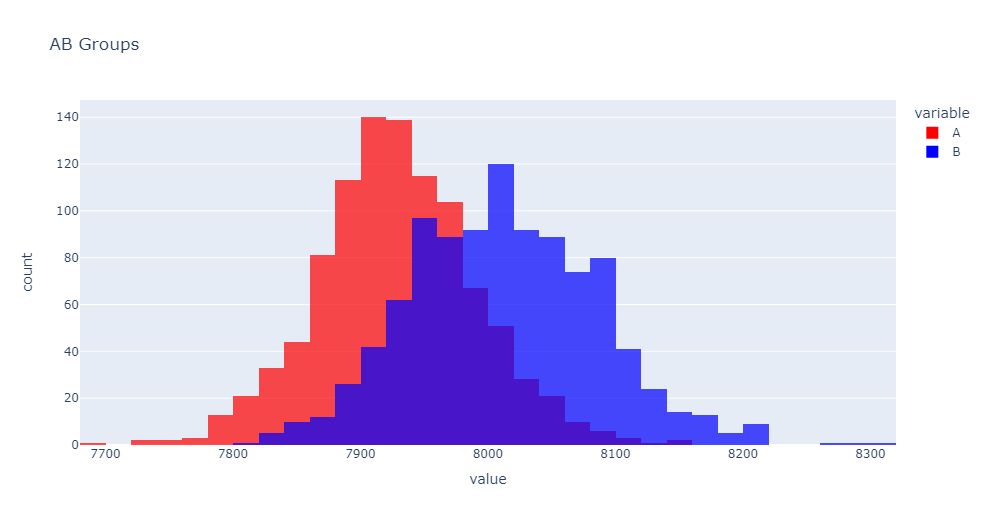